In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Data Model: data = signal+noise    
signal           = Ax+mu  
x is a random number drawn from a standard normal distribution, < x >=0, <x^2>=1    
the noise is Gaussian with mean =< noise >=0 and variance = < ( x-< x >)**2 >=sigma^2

A and mu depend on the parameters a,b. a and b are the parameters we are interested in inferring.

In [ ]:
#get A as a function of a,b
def get_A(a,b,dim=1):
    A = a**2*np.ones((dim,dim))+b/2.
    return A

In [ ]:
#get mu as a function of a,b
def get_mu(a,b, dim=1):
    mu = a**3/np.exp(b)*np.ones(dim)
    return mu

Fiducial Parameters (this is the underlying truth)

In [ ]:
a_0=2; b_0=0.5

In [ ]:
A_0  = get_A(a_0,b_0)
mu_0 = get_mu(a_0, b_0)

Noise level

In [ ]:
sigma = 0.1

In [16]:
def generate_noise(sigma,dim=1,nsamples=100,rand_seed=None):
    np.random.seed(rand_seed)
    noise = np.random.randn(nsamples,dim)*sigma
    return noise

In [17]:
def generate_signal(A,mu,sigma,dim=1, nsamples=100,rand_seed=None):
    np.random.seed(rand_seed)
    x      = np.random.randn(nsamples,dim)
    signal = A*x+mu
    return signal

In [18]:
def generate_data(A,mu,sigma,dim,nsamples,rand_seed=None):
    
    signal = generate_signal(A,mu,sigma,dim,nsamples,rand_seed)
    noise  = generate_noise(sigma,dim,nsamples,rand_seed)
    
    data   = signal+noise
    
    return data

fiducial data (that's the assumed truth)

In [44]:
fid_data = generate_data(A_0,mu_0,sigma,dim=1, nsamples=1000,rand_seed=None)

In [45]:
def Gaussian(x,Mu,Sigma):
    return 1/np.sqrt(np.pi*2.)/Sigma*np.exp(-0.5*(x-Mu)**2/Sigma**2)

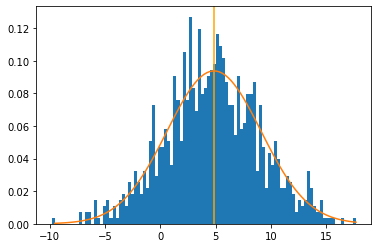

In [58]:
_, bins,_ = plt.hist(fid_data, density=True,bins=100)
plt.axvline(mu_0,color='orange')
delta = np.diff(bins) 
bins  = bins[0:-1]+delta
plt.plot(bins,np.squeeze(Gaussian(bins,mu_0,(A_0**2+sigma**2)**(0.5))))
plt.show()